In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import base64
import os
import folium
import geopandas as gpd
import glob
from rasterio.windows import from_bounds
from rasterio.plot import show
from rasterio.features import geometry_window
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from pyimpute import load_training_vector
from pyimpute import load_targets
from pyimpute import impute
from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier
from io import BytesIO
from shapely.geometry import box
from shapely.geometry import Point
from shapely.ops import unary_union
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from branca.colormap import linear

In [2]:
# Importing pandas for data manipulation and analysis.
import pandas as pd

## Data pre-processing

In [3]:
# df = pd.read_csv("data/bats.tsv", sep='\t')
df = pd.read_csv("./data/nestle_data.csv", sep='\t')
df.head(1)

/var/folders/b5/7cx0sbfd5lxddb1vjr5zn7zw0000gn/T/ipykernel_72192/1574231192.py:2: DtypeWarning: Columns (10,39,46) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./data/nestle_data.csv", sep='\t')


,gbifID,datasetKey,occurrenceID,kingdom,phylum,class,order,family,genus,species,...,identifiedBy,dateIdentified,license,rightsHolder,recordedBy,typeStatus,establishmentMeans,lastInterpreted,mediaType,issue
0,912446076,cd6e21c8-9e8a-493a-8a76-fbf7862069e5,http://specimens.kew.org/herbarium/K000537728,Plantae,Tracheophyta,Polypodiopsida,Schizaeales,Lygodiaceae,Lygodium,Lygodium smithianum,...,NaN,NaN,CC_BY_4_0,NaN,"Viane, R.",NaN,NaN,2024-04-30T17:16:39.543Z,NaN,COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS8...


In [4]:
species_counts = df['species'].value_counts()
species_counts.head()

species
Turtur brehmeri              427
Stizorhina finschi           427
Stiphrornis erythrothorax    425
Apalis sharpii               406
Dicrurus atripennis          400
Name: count, dtype: int64

In [5]:
species_counts.to_csv('nestle_unique_endangered_species.csv')

In [6]:
turtur = df[df['speciesKey']==5231787]
len(turtur)

427

In [75]:
turtur.to_csv('bird.csv')

In [7]:
# Taking only the latitude and longitude columns
coords = turtur[['decimalLatitude', 'decimalLongitude']]
coords

,decimalLatitude,decimalLongitude
654,5.690694,-7.050476
886,5.668818,-7.069220
2079,5.834547,-7.409798
2345,5.877514,-7.245007
2388,5.690694,-7.050476
...,...,...
47592,5.833300,-7.350000
47691,5.833300,-7.350000
47741,5.833300,-7.350000
47894,5.833300,-7.350000


In [8]:
# Removing duplicate entries to ensure unique coordinate points for analysis.
coords_unique = coords.drop_duplicates()
coords_unique

,decimalLatitude,decimalLongitude
654,5.690694,-7.050476
886,5.668818,-7.069220
2079,5.834547,-7.409798
2345,5.877514,-7.245007
9243,5.852570,-7.406178
16736,6.181500,-8.122200
19703,6.174000,-7.788000
25529,5.833333,-7.300000
25664,5.833300,-7.350000
25763,5.850000,-7.383333


In [9]:
# Displaying the minimum latitude and longitude values to understand geographical extent.
print(coords_unique.decimalLatitude.min())
print(coords_unique.decimalLatitude.max())

5.668818
6.1815


In [10]:
# Displaying the minimum latitude and longitude values to understand geographical extent.
print(coords_unique.decimalLongitude.min())
print(coords_unique.decimalLongitude.max())

-8.1222
-7.050476


In [11]:
coords_unique.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11 entries, 654 to 25924
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   decimalLatitude   11 non-null     float64
 1   decimalLongitude  11 non-null     float64
dtypes: float64(2)
memory usage: 264.0 bytes


# Cropping the Bioclim raster files
This section focuses on preparing environmental data by cropping raster files to the specific geographic extent. This step is essential to ensure that the model predictions are based on the precise area of interest for biodiversity conservation.

In [12]:
# Define the nestle service area extent: latitude ~12°N and ~4°S and between longitudes ~67° and ~79°W.
lat_extent = [5.0, 7.0]
long_extent = [-8.8, -6.3]
# Define the extent coordinates of the bird (west, south, east, north)
# west, south, east, north = -79, -4.3, -67, 12
west, south, east, north = -8.122, 5.668, -7.050, 6.181

In [13]:
# Specify the directory containing the raster files
input_directory = 'data/wc2-2/'
output_directory = 'inputs/cropped_bioclim_bird'

# Define geographic coordinates for the bounding box
west, south, east, north = -10, 4, -5, 8

In [14]:
def process_raster_files(directory, west, south, east, north, output_dir):
    """
    Processes raster files by cropping them to a specified geographic extent and saving
    the results in ASCII format.

    Parameters:
    - directory (str): The path to the directory containing the raster files.
    - west (float): The western boundary of the cropping window in geographic coordinates.
    - south (float): The southern boundary of the cropping window in geographic coordinates.
    - east (float): The eastern boundary of the cropping window in geographic coordinates.
    - north (float): The northern boundary of the cropping window in geographic coordinates.
    - output_dir (str): The path to the directory where the cropped files will be saved. This
                        directory will be created if it does not exist.

    Each output ASCII file is named after the original file with an additional suffix indicating
    the band number (e.g., 'filename_band1.asc').

    Returns:
    None
    """
    # Create the output directory if it does not exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Walk through all files in the input directory
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.tif'):
                file_path = os.path.join(root, file)
                with rasterio.open(file_path) as src:
                    # Convert geographic coordinates to raster window
                    window = from_bounds(west, south, east, north, src.transform)

                    # Read the data in the window, cropping to the extent
                    data = src.read(window=window)

                    # Loop through each band and write to ASCII
                    for i in range(1, src.count + 1):
                        output_path = os.path.join(output_dir, f'{os.path.splitext(file)[0]}_band{i}.asc')
                        with rasterio.open(output_path, 'w', driver='AAIGrid', height=window.height, width=window.width,
                                           count=1, dtype=data.dtype, transform=rasterio.windows.transform(window, src.transform)) as dst:
                            dst.write(data[i-1], 1)  # Write each band to a new file


In [15]:
# Processing raster files to align with the study area. This step crops the rasters to the specific geographical extent needed for the species distribution model.
process_raster_files(input_directory, west, south, east, north, output_directory)

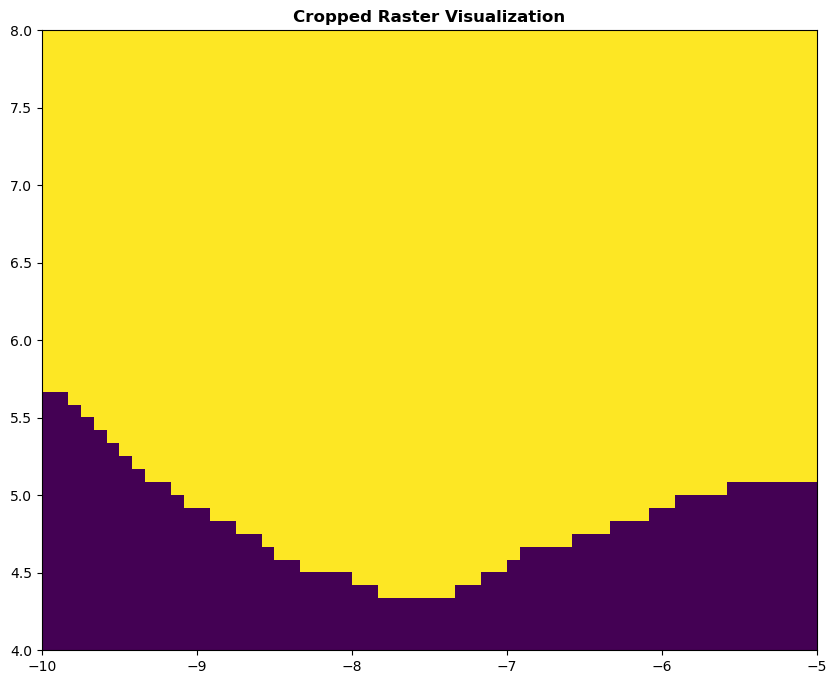

In [16]:
# Making sure the cropping worked

# Path to the raster file you want to check
file_path = 'inputs/cropped_bioclim_bird/wc2.1_5m_tmin_01_band1.asc'

# Open the raster file
with rasterio.open(file_path) as src:
    # Read the first band (assuming the file is single-band)
    data = src.read(1)
    
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Use rasterio's show method, which handles GeoTransforms correctly
    show(data, ax=ax, transform=src.transform, title='Cropped Raster Visualization')
    plt.show()

In [17]:
# Utilizing Folium for interactive mapping, crucial for visualizing species distribution and making the results accessible to conservationists and the public.
# Again, making sure cropping worked.

# Map centered around the rough middle of the Colombian Amazon
m = folium.Map(location=[6, -8], zoom_start=7)

# Define the boundaries
# Define geographic coordinates for the bounding box
west, south, east, north = -10, 4, -5, 8

# Create a rectangle to represent the extent
folium.Rectangle(
    bounds=[[south, west], [north, east]],
    color='red',
    fill=True,
    fill_color='red',
    fill_opacity=0.2,
).add_to(m)

# Display the map
m


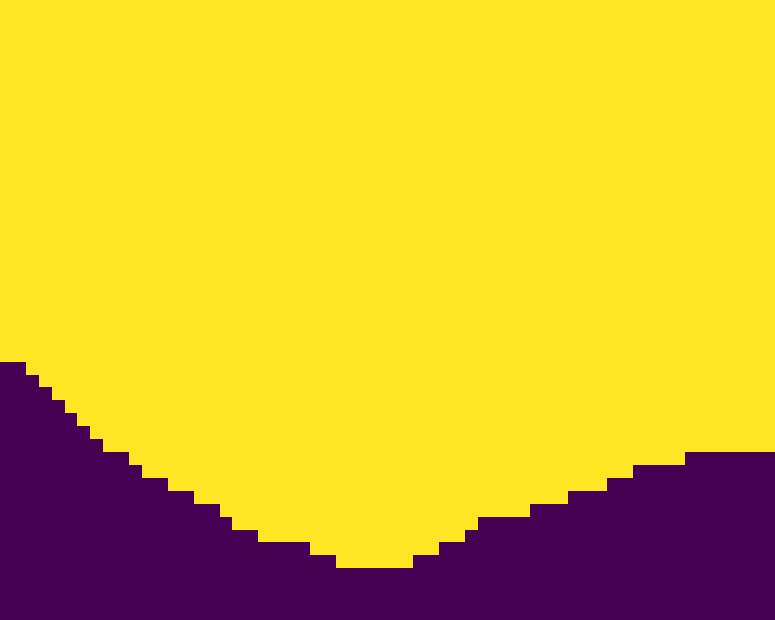

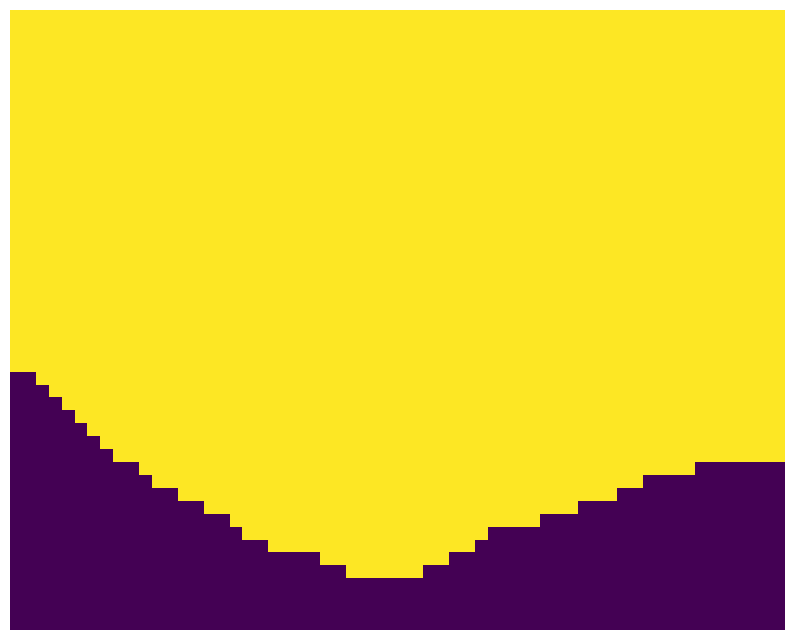

In [18]:
# Testing overlay of bioclim variable raster on folium map - working. 

# Load raster data
with rasterio.open('inputs/cropped_bioclim_bird/wc2.1_5m_tmin_01_band1.asc') as src:
    # Make a note of the raster bounds
    bounds = src.bounds
    
    # Read the data (e.g., first band)
    data = src.read(1)
    
    # Normalize the data for better visualization
    data = (data - data.min()) / (data.max() - data.min())
    
    # Create a plot
    fig, ax = plt.subplots(frameon=False, figsize=(10, 10))
    plt.axis('off')
    colormap = plt.cm.viridis  # You can change the colormap to something appropriate for your data
    show(data, ax=ax, cmap=colormap, transform=src.transform, adjust='datalim')
    
    # Save the plot to a PNG image in memory
    img = BytesIO()
    plt.savefig(img, format='png', bbox_inches='tight', pad_inches=0, transparent=True)
    img.seek(0)
    img_base64 = base64.b64encode(img.read()).decode('utf-8')

# Define the image overlay bounds
image_bounds = [[bounds.bottom, bounds.left], [bounds.top, bounds.right]]

# Create a folium map centered on your data
m = folium.Map(location=[(bounds.top + bounds.bottom) / 2, (bounds.left + bounds.right) / 2], zoom_start=5)

# Add the image overlay to the map
folium.raster_layers.ImageOverlay(
    image='data:image/png;base64,' + img_base64,
    bounds=image_bounds,
    opacity=0.6  # Adjust opacity as needed
).add_to(m)

# Display the map
m

# Presence & Absence Sampling + Creating a geodatabase shape file
Creating a database of species presence and absence is crucial for training the model. This data helps in understanding species distribution and is vital for accurate model training.

In [19]:
# Function to generate background points based on extent of presence points
def sample_background_points(raster, num_points, extent_factor):
    """
    Samples a specified number of random geographic background points from within
    an expanded bounding box around a raster's original bounds. This expansion helps
    mitigate edge effects in spatial analysis by allowing background sampling from
    a broader area.

    Parameters:
    - raster (str): The file path to the raster file from which bounds are derived.
    - num_points (int): The number of random points to generate within the expanded extent.
    - extent_factor (float): The factor by which to expand the raster's bounding box. A factor
                             of 1.25 would increase the extent by 25%.

    Returns:
    - points (GeoDataFrame): A GeoDataFrame containing the filtered points that lie within
                             the original raster's extent.

    Each point is represented as a geometry in the returned GeoDataFrame, suitable for
    further geospatial analysis.
    """
    with rasterio.open(raster) as src:
        # Create a bounding box that is 25% larger (sampling from a larger area helps with edge effects)
        b = src.bounds
        width = (b.right - b.left) * (extent_factor - 1) / 2
        height = (b.top - b.bottom) * (extent_factor - 1) / 2
        larger_extent = box(b.left - width, b.bottom - height, b.right + width, b.top + height)

        # Generate random points within the larger extent
        xs = np.random.uniform(b.left - width, b.right + width, num_points)
        ys = np.random.uniform(b.bottom - height, b.top + height, num_points)

        # Filter points to lie within the original raster extent
        points = gpd.GeoDataFrame(geometry=gpd.points_from_xy(xs, ys))
        original_extent = box(b.left, b.bottom, b.right, b.top)
        points = points[points.geometry.within(original_extent)]

    return points



In [24]:
# Path to the bioclimatic variable raster
raster_path = './inputs/cropped_bioclim_bird/wc2.1_5m_tmin_01_band1.asc'

# Number of presence points (in dataframe of occurrences)
length_presences = len(coords_unique)

# Sample background points
background_points = sample_background_points(raster_path, length_presences * 2, 1.25)

# Rename columns to 'lon' and 'lat'
background_points['decimalLongitude'] = background_points.geometry.x
background_points['decimalLatitude'] = background_points.geometry.y

# Create the training data by combining presence and background points
train = pd.concat([coords_unique, background_points[['decimalLongitude', 'decimalLatitude']]], ignore_index=True)

# Create presence-absence column
pa_train = np.concatenate([np.ones(len(coords_unique)), np.zeros(len(background_points))])

# Final DataFrame
train = pd.DataFrame({'CLASS': pa_train, 'lon': train['decimalLongitude'], 'lat': train['decimalLatitude']})

In [25]:
train

,CLASS,lon,lat
0,1.0,-7.050476,5.690694
1,1.0,-7.069220,5.668818
2,1.0,-7.409798,5.834547
3,1.0,-7.245007,5.877514
4,1.0,-7.406178,5.852570
5,1.0,-8.122200,6.181500
6,1.0,-7.788000,6.174000
7,1.0,-7.300000,5.833333
8,1.0,-7.350000,5.833300
9,1.0,-7.383333,5.850000


In [27]:
# Check coordinate reference system (crs)
with rasterio.open('data/wc2-2/wc2.1_5m_tmin_01.tif') as src:
    # Print the CRS
    print(src.crs)

EPSG:4326


In [29]:
# Creating the shape files needed for modeling in section 2
# Shuffle the DataFrame
train = train.sample(frac=1).reset_index(drop=True)

# Extract the 'CLASS' column into a separate DataFrame and name the column
class_pa = pd.DataFrame(train.iloc[:, 0])
class_pa.columns = ['CLASS']

# Assuming 'train' has longitude in the 2nd column and latitude in the 3rd column
# Create the GeoDataFrame
geometry = [Point(xy) for xy in zip(train.iloc[:, 1], train.iloc[:, 2])]
data_map = gpd.GeoDataFrame(class_pa, geometry=geometry)

data_map.crs = 'EPSG:4326'  # Directly setting EPSG code

# Write to shapefile
data_map.to_file('inputs/bird.shp', driver='ESRI Shapefile')

In [43]:
# Read shapefile as a geodataframe
pa = gpd.GeoDataFrame.from_file("inputs/bird.shp")
pa.sample(5) # GeoDataFrame for the species

,CLASS,geometry
0,0.0,POINT (-6.72608 4.74198)
22,1.0,POINT (-7.40980 5.83455)
21,1.0,POINT (-7.30000 5.83333)
6,1.0,POINT (-7.24501 5.87751)
4,1.0,POINT (-7.05048 5.69069)


In [44]:
print("number of duplicates: ", pa.duplicated(subset='geometry', keep='first').sum())
print("number of NA's: ", pa['geometry'].isna().sum())
print("Coordinate reference system is: {}".format(pa.crs))
print("{} observations with {} columns".format(*pa.shape))

number of duplicates:  0
number of NA's:  0
Coordinate reference system is: EPSG:4326
27 observations with 2 columns


### Plotting geospatial data to visually inspect the presence of species across different locations.



In [45]:
pa[pa.CLASS == 1]

,CLASS,geometry
3,1.0,POINT (-7.78800 6.17400)
4,1.0,POINT (-7.05048 5.69069)
6,1.0,POINT (-7.24501 5.87751)
11,1.0,POINT (-8.12220 6.18150)
12,1.0,POINT (-7.30000 5.83333)
16,1.0,POINT (-7.35000 5.83330)
17,1.0,POINT (-7.06922 5.66882)
19,1.0,POINT (-7.40618 5.85257)
21,1.0,POINT (-7.30000 5.83333)
22,1.0,POINT (-7.40980 5.83455)


In [46]:
pa['longitude'] = pa.geometry.x
pa['latitude'] = pa.geometry.y

In [47]:
pa = pa[(pa['longitude'] >= -180) & (pa['longitude'] <= 180)]
pa = pa[(pa['latitude'] >= -90) & (pa['latitude'] <= 90)]
pa

,CLASS,geometry,longitude,latitude
0,0.0,POINT (-6.72608 4.74198),-6.726078,4.741976
1,0.0,POINT (-5.23437 4.10149),-5.234365,4.101491
2,0.0,POINT (-5.37178 4.53057),-5.371784,4.530574
3,1.0,POINT (-7.78800 6.17400),-7.788000,6.174000
4,1.0,POINT (-7.05048 5.69069),-7.050476,5.690694
5,0.0,POINT (-7.87798 4.87128),-7.877978,4.871281
6,1.0,POINT (-7.24501 5.87751),-7.245007,5.877514
7,0.0,POINT (-9.31353 5.91150),-9.313526,5.911504
8,0.0,POINT (-8.18989 4.65697),-8.189894,4.656973
9,0.0,POINT (-9.90067 5.95874),-9.900671,5.958740


/var/folders/b5/7cx0sbfd5lxddb1vjr5zn7zw0000gn/T/ipykernel_72192/2941155850.py:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


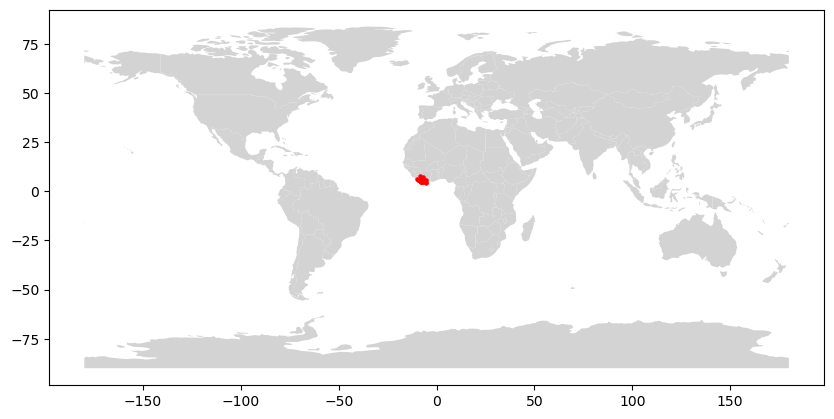

In [48]:
# Plot
fig, ax = plt.subplots(figsize=(10, 10))
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax, color='lightgrey')
pa.plot(ax=ax, marker='o', color='red', markersize=5)  # Plotting points in red
plt.show()

<Axes: >

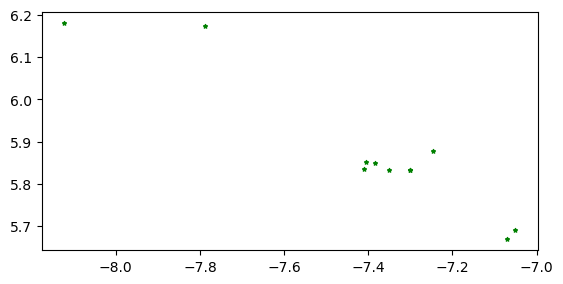

In [49]:
pa[pa.CLASS == 1].plot(marker='*', color='green', markersize=8)

In [52]:
pa

,CLASS,geometry,longitude,latitude
0,0.0,POINT (-6.72608 4.74198),-6.726078,4.741976
1,0.0,POINT (-5.23437 4.10149),-5.234365,4.101491
2,0.0,POINT (-5.37178 4.53057),-5.371784,4.530574
3,1.0,POINT (-7.78800 6.17400),-7.788000,6.174000
4,1.0,POINT (-7.05048 5.69069),-7.050476,5.690694
5,0.0,POINT (-7.87798 4.87128),-7.877978,4.871281
6,1.0,POINT (-7.24501 5.87751),-7.245007,5.877514
7,0.0,POINT (-9.31353 5.91150),-9.313526,5.911504
8,0.0,POINT (-8.18989 4.65697),-8.189894,4.656973
9,0.0,POINT (-9.90067 5.95874),-9.900671,5.958740


<Axes: >

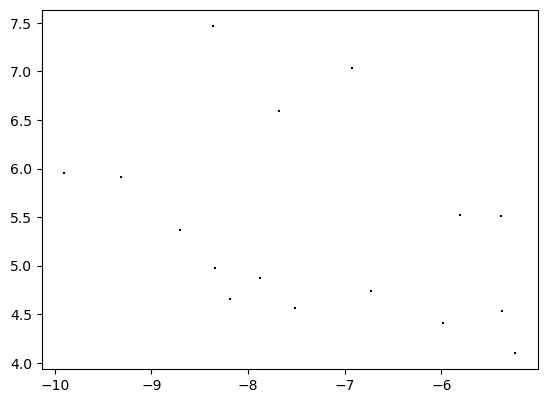

In [53]:
pa[pa.CLASS == 0].plot(marker='+', color='black', markersize=4)

In [54]:
# Pickling the cleaned presence absence geodataframe for later use in modeling
pa.to_pickle('inputs/bird_pa.pickle')

In [3]:
# Load the presence absence geodataframe
pa = pd.read_pickle('inputs/bird_pa.pickle')
pa = gpd.GeoDataFrame(pa)
pa.head()

,CLASS,geometry,longitude,latitude
0,0.0,POINT (-6.72608 4.74198),-6.726078,4.741976
1,0.0,POINT (-5.23437 4.10149),-5.234365,4.101491
2,0.0,POINT (-5.37178 4.53057),-5.371784,4.530574
3,1.0,POINT (-7.78800 6.17400),-7.788000,6.174000
4,1.0,POINT (-7.05048 5.69069),-7.050476,5.690694


In [4]:
pa.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   CLASS      27 non-null     float64 
 1   geometry   27 non-null     geometry
 2   longitude  27 non-null     float64 
 3   latitude   27 non-null     float64 
dtypes: float64(3), geometry(1)
memory usage: 992.0 bytes


# Using PyImpute to generate raster maps of suitability
Applying machine learning techniques to predict species distribution across geographic areas. This involves using training data to estimate suitability maps, which are crucial for decision-making in conservation.

In [57]:
# First grab all the climate features from input folder
raster_features = sorted(glob.glob(
    'inputs/cropped_bioclim_bird/wc2*.asc'))

print('\nThere are', len(raster_features), 'raster features.') # should be 19



There are 12 raster features.


In [58]:
# Using PyImpute for spatial prediction of species distribution, leveraging existing spatial datasets.
train_xs, train_y = load_training_vector(pa, raster_features, response_field='CLASS')
target_xs, raster_info = load_targets(raster_features)
train_xs.shape, train_y.shape # check shape, does it match the size above of the observations?

/opt/homebrew/anaconda3/envs/gis/lib/python3.12/site-packages/rasterstats/io.py:328: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


((27, 12), (27,))

In [6]:
import pickle

In [60]:

# Using pickle to save and load processed geospatial data efficiently, useful for large datasets.
with open('training_data.pkl', 'wb') as f:
    pickle.dump((train_xs, train_y), f)

with open('target_data.pkl', 'wb') as f:
    pickle.dump((target_xs, raster_info), f)

In [7]:
# To reload training data
with open('training_data_bird.pkl', 'rb') as f:
    train_xs, train_y = pickle.load(f)

with open('target_data_bird.pkl', 'rb') as f:
    target_xs, raster_info = pickle.load(f)

In [8]:
CLASS_MAP = {
    'rf': (RandomForestClassifier()),
    'et': (ExtraTreesClassifier()),
    'xgb': (XGBClassifier()),
    }

In [10]:
from sklearn.metrics import make_scorer, precision_score, recall_score

# Using PyImpute for spatial prediction of species distribution, leveraging existing spatial datasets.

# Model fitting and evaluation
for name, (model) in CLASS_MAP.items():
    # cross validation for accuracy scores (displayed as a percentage)
    k = 5 # k-fold
    kf = model_selection.KFold(n_splits=k)

    # Scoring metrics: accuracy, precision, and recall
    scoring = {
        'accuracy': 'accuracy',
        'precision': make_scorer(precision_score, average='weighted'), # Weighted accounts for class imbalance.
        'recall': make_scorer(recall_score, average='binary')
    }

    # Calculate scores
    scores = model_selection.cross_validate(model, train_xs, train_y, cv=kf, scoring=scoring)

    # Display scores
    print(f"{name} {k}-fold Cross Validation:")
    print(f"Accuracy: {scores['test_accuracy'].mean() * 100:.2f}% (+/- {scores['test_accuracy'].std() * 200:.2f})")
    print(f"Precision: {scores['test_precision'].mean() * 100:.2f}% (+/- {scores['test_precision'].std() * 200:.2f})")
    print(f"Recall: {scores['test_recall'].mean() * 100:.2f}% (+/- {scores['test_recall'].std() * 200:.2f})")
    
    # spatial prediction
    model.fit(train_xs, train_y)
    impute(target_xs, model, raster_info, outdir='outputs/' + name + '-images_bird',
           class_prob=True, certainty=True)

rf 5-fold Cross Validation:
Accuracy: 81.33% (+/- 3.27)
Precision: 86.33% (+/- 1.33)
Recall: 80.00% (+/- 48.99)
et 5-fold Cross Validation:
Accuracy: 81.33% (+/- 3.27)
Precision: 86.33% (+/- 1.33)
Recall: 80.00% (+/- 48.99)
xgb 5-fold Cross Validation:
Accuracy: 86.00% (+/- 25.44)
Precision: 87.67% (+/- 24.55)
Recall: 80.00% (+/- 48.99)


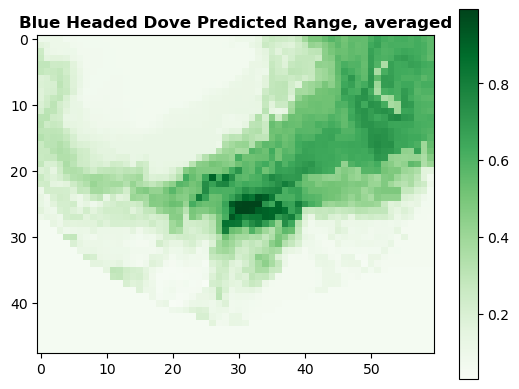

In [66]:
# define spatial plotter
def plotit(x, title, cmap="Blues"):
    plt.imshow(x, cmap=cmap, interpolation='nearest')
    plt.colorbar()
    plt.title(title, fontweight = 'bold')

distr_rf = rasterio.open("outputs/rf-images_bird/probability_1.0.tif").read(1)
distr_et = rasterio.open("outputs/et-images_bird/probability_1.0.tif").read(1)
distr_xgb =  rasterio.open("outputs/xgb-images_bird/probability_1.tif").read(1)

distr_averaged = (distr_rf + distr_et + distr_xgb)/3

plotit(distr_averaged, "Blue Headed Dove Predicted Range, averaged", cmap="Greens")

# Converting raster output to GeoJSON for Folium map overlay
This conversion is necessary for integrating model outputs with web applications, allowing users to interact with and explore the geographic distributions of species.

In [15]:
# Create a colormap for visualization - need this to represent different data values visually
colormap = linear.YlGnBu_09.scale(0, distr_averaged.max())
colormap.caption = 'Probability Distribution'

In [73]:
# Convert raster to image overlay: using matplotlib to create rgbs image of raster

# Normalize the raster data: scale from 0 to 1 to make sure values are within valid range for colormap
norm = Normalize(vmin=distr_averaged.min(), vmax=distr_averaged.max())
# Using a Matplotlib colormap
cmap = plt.cm.YlGnBu  

# Create a ScalarMappable with your normalization and colormap
mappable = ScalarMappable(norm=norm, cmap=cmap)

# Apply the colormap to the normalized data to get an RGBA image
rgba_image = mappable.to_rgba(distr_averaged)

# Save the image to a PNG file
plt.imsave('outputs/distr_averaged_bird.png', rgba_image, format='png')


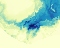

In [74]:
# Open the raster file to find bounds
with rasterio.open("outputs/rf-images_bird/probability_1.0.tif") as src:
    bounds = src.bounds
    crs = src.crs

# Assuming your map's initial focus point and zoom level
m = folium.Map(location=[5, -7], zoom_start=7)

# Add the image overlay
folium.raster_layers.ImageOverlay(
    image='outputs/distr_averaged_bird.png',
    bounds=[[bounds.bottom, bounds.left], [bounds.top, bounds.right]],
    opacity=0.6,
    interactive=True,
    cross_origin=False,
    zindex=1,
).add_to(m)

m